Hrubá pipeline z článku Toroidal topology of population activity in
grid cells https://doi.org/10.1038/s41586-021-04268-7. Grid cells jsou buňky v entorhinální kůře myši, kódující prostorovou orientaci. Mapa jejich aktivací v prostoru vytváří "dláždicový" patern. V článku se ukazuje, že "joint activity of grid cells ... resides on a toroidal manifold". Tj. lze z projekce signálu grid cells na torus, lze zjistit, kde se myš nachází v prostoru.

Pipeline sketch: Load data time series -> cluster neurons -> bin -> smooth -> PCA -> UMAP -> decode + quantify

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.decomposition import PCA
import umap
from sklearn.cluster import KMeans
from ripser import Rips
import plotly.graph_objs as go
import matplotlib.cm as cm
import math
from scipy.ndimage import gaussian_filter1d

In [4]:
signal_path = '/home/martin/Coding/TorusTopology/DataR1/spikes_mod2.npy'
time_path = '/home/martin/Coding/TorusTopology/DataR1/t.npy'
x_path = '/home/martin/Coding/TorusTopology/DataR1/x.npy'
y_path = '/home/martin/Coding/TorusTopology/DataR1/y.npy'
z_path = '/home/martin/Coding/TorusTopology/DataR1/z.npy'

In [5]:
#load npy arrays
signal = np.load(signal_path, allow_pickle=True).item()
time = np.load(time_path)
x = np.load(x_path)
y = np.load(y_path) 
z = np.load(z_path)

for key, arr in signal.items():
    print(f"Length of array with key {key}: {len(arr)}")
print(x.shape, y.shape, z.shape)

Length of array with key 0: 11254
Length of array with key 1: 18523
Length of array with key 2: 12465
Length of array with key 3: 14215
Length of array with key 4: 25026
Length of array with key 5: 16502
Length of array with key 6: 25776
Length of array with key 7: 27973
Length of array with key 8: 10871
Length of array with key 9: 13144
Length of array with key 10: 14362
Length of array with key 11: 16326
Length of array with key 12: 10323
Length of array with key 13: 16570
Length of array with key 14: 12852
Length of array with key 15: 23721
Length of array with key 16: 17466
Length of array with key 17: 26053
Length of array with key 18: 18286
Length of array with key 19: 14821
Length of array with key 20: 17777
Length of array with key 21: 687
Length of array with key 22: 19395
Length of array with key 23: 41667
Length of array with key 24: 28744
Length of array with key 25: 26298
Length of array with key 26: 34511
Length of array with key 27: 52633
Length of array with key 28: 457

In [6]:
#Bin array [neurons,time] in time for each neuron using mean. 
def bin_multiple_array(array, bin_size):
    # Reshape 1D array to 2D array
    if array.ndim == 1:
        array = array.reshape(1, -1)  

    num_neurons, num_timepoints = array.shape

    num_bins = num_timepoints // bin_size

    binned_multiple_array = np.zeros((num_neurons, num_bins))

    for bin_idx in range(num_bins):
        start_idx = bin_idx * bin_size
        end_idx = min((bin_idx + 1) * bin_size, num_timepoints)
        binned_multiple_array[:, bin_idx] = np.mean(array[:, start_idx:end_idx], axis=1)

    return np.squeeze(binned_multiple_array)

def plot_spike_heatmap(spike_array, cmap='viridis', xlabel='Time Bins', ylabel='Neurons', title='Spike Heatmap', colorbar_label='Spike Presence'):
    plt.imshow(spike_array, cmap=cmap, aspect='auto')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.colorbar(label=colorbar_label)
    plt.show()

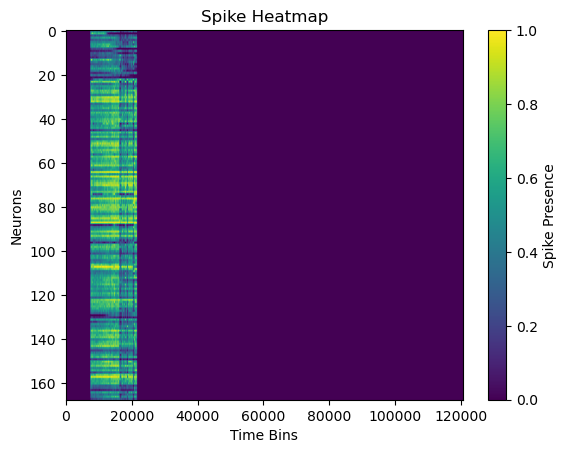

In [232]:
max_length = max(len(arr) for arr in signal.values())

spike_array = np.zeros((len(signal), max_length))

# Fill in the array with spike presence, floor() bins the signal array, could be fixed if Hz or signal_start/end known beforehand
for i, (key, arr) in enumerate(signal.items()):
    for j in arr:
        spike_array[i,math.floor(j) ] = 1

plot_spike_heatmap(spike_array)

In [415]:
#extract signal
last_nonzero_time = np.max(np.where(np.any(spike_array != 0, axis=0)))
first_nonzero_time = np.min(np.where(np.any(spike_array != 0, axis=0)))

spikes = spike_array[:,first_nonzero_time:last_nonzero_time]

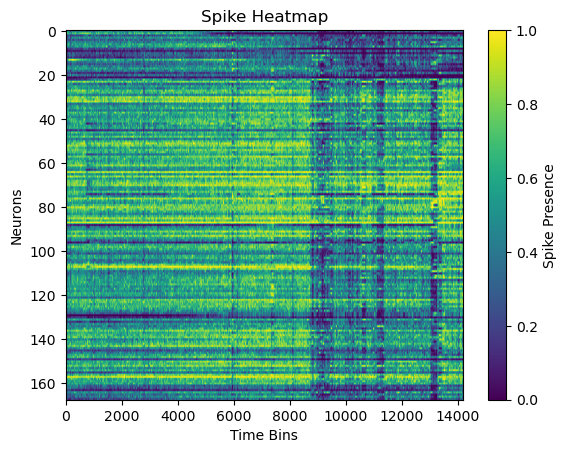

In [416]:
plot_spike_heatmap(spikes)

In [417]:
#position and signal were recorderded differently and have to be aligned
print(spikes.shape, x.shape, y.shape)

x = x[0:spikes.shape[1]*100]
y = y[0:spikes.shape[1]*100]
aligned_x = bin_multiple_array(x,100)
aligned_y = bin_multiple_array(y,100)

print(aligned_x.shape, aligned_y.shape)

(168, 14182) (1418200,) (1418200,)
(14182,) (14182,)


In [494]:
#in the paper, 3 different types of neurons were identified by clustering neuron autocorrelograms
#skipped

clustered_spikes = []

# autocorrelograms = []
# for neuron_data in spikes:
#     autocorr = np.correlate(neuron_data, neuron_data, mode='full')
#     autocorrelograms.append(autocorr[len(neuron_data)-1:])

# autocorrelograms_array = np.array(autocorrelograms)

# num_clusters = 2

# kmeans = KMeans(n_clusters=num_clusters, random_state=42)
# clusters = kmeans.fit_predict(autocorrelograms_array)

# clustered_spikes = [spikes[clusters == i] for i in range(num_clusters)]

In [495]:
#in the paper, binned by 10 ms, but Hz not known so binned as convenient 
#Skipped binning by position/time

clustered_spikes.insert(0, spikes)
neuron_arrays = np.array(clustered_spikes) 
smoothed_arrays = []

bin_size = 5

for neuron_array in neuron_arrays:
    binned_array = bin_multiple_array(neuron_array,bin_size)
    smoothed_array = np.array([gaussian_filter1d(signal, sigma=1, axis=-1) for signal in binned_array])
    smoothed_arrays.append(smoothed_array)
    
binned_x = bin_multiple_array(aligned_x,bin_size)
binned_y = bin_multiple_array(aligned_y,bin_size)


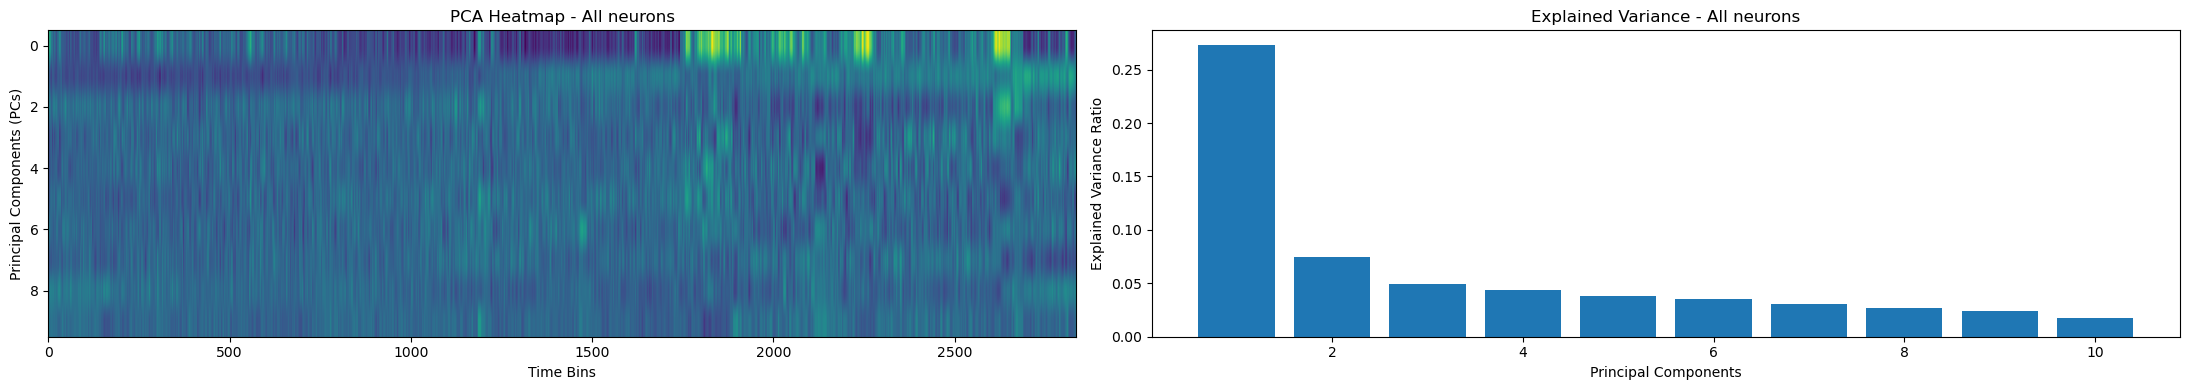

In [496]:
pca_signals = []

fig, axes = plt.subplots(nrows=1, ncols=len(neuron_arrays)*2, figsize=(22, 4))
# Perform PCA and create plots for each set of smoothed signals
for i, (smoothed_signals, title_suffix) in enumerate(zip(smoothed_arrays,
                                                          ['All neurons', 'Cluster 1', 'Cluster 2', 'Cluster3'])):
    # Apply PCA to remove noise/find relevant PCs
    pca = PCA(n_components=10)
    pca_signal = pca.fit_transform(smoothed_signals.T).T
    pca_signals.append(pca_signal[:6])
    explained_variance_ratio = pca.explained_variance_ratio_

    # PCA Heatmap
    axes[i * 2].imshow(pca_signal, cmap='viridis', aspect='auto')
    axes[i * 2].set_title(f'PCA Heatmap - {title_suffix}')
    axes[i * 2].set_xlabel('Time Bins')
    axes[i * 2].set_ylabel('Principal Components (PCs)')

    # Explained variance ratio bar plot
    axes[i * 2 + 1].bar(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio)
    axes[i * 2 + 1].set_title(f'Explained Variance - {title_suffix}')
    axes[i * 2 + 1].set_xlabel('Principal Components')
    axes[i * 2 + 1].set_ylabel('Explained Variance Ratio')

plt.tight_layout()
plt.show()


In [497]:
#apply umap, a non-linear dimensionality reduction technique to find a manifold underlying grid cell activity
#activity of a module of grid cells was found to be underlied by a toroidal-shaped manifold
embeddings = []
for signal in pca_signals:
    reducer = umap.UMAP(n_components=3, metric='cosine', n_neighbors=15, min_dist=1)
    embedding = reducer.fit_transform(signal.T)
    aligned_embedding = align_point_cloud(embedding)
    embeddings.append(aligned_embedding)

In [498]:
#Mouse is moving on a 2d XxY plane. Bin the 2d XxY plane into several tiles and label them with different numbers
#Each grid cell fires at a specific location on the plane. Tiles should somewhat approximate the grid cells and map
# each grid cell to a different color.
#after projecting data on lower dimensions, grid cells/tiles/colors should be somewhat clustered together
def index_domain_by_values(data, N, multiplier=1):
    hist, bin_edges = np.histogram(data, bins=N)
    indices = np.ones(data.shape[0])*multiplier
    
    for i in range(N):
        bin_indexes = np.where((data >= bin_edges[i]) & (data <= bin_edges[i + 1]))[0]
        indices[bin_indexes] += i
    
    return indices

N = 9

indices1 = index_domain_by_values(binned_x,N)
indices2 = index_domain_by_values(binned_y, N, multiplier=N+1)
positions = indices1 + indices2

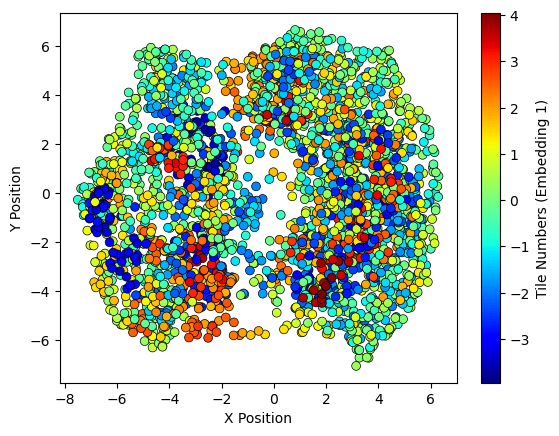

In [499]:
def scatterplot_with_color(data, x_label='X Position', y_label='Y Position', color_label='tile numbers', size=40, edgecolors='k', linewidths=0.5, cmap='jet'):
    plt.scatter(data[:, 0], data[:, 1], c=data[:, 2], cmap=cmap, s=size, edgecolors=edgecolors, linewidths=linewidths)
    plt.colorbar(label=color_label)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.show()
    
for i, embedding in enumerate(embeddings):
    combined_data = np.column_stack((embedding, positions))
    scatterplot_with_color(combined_data, color_label=f'Tile Numbers (Embedding {i + 1})')


In [500]:
def create_embedding_plot(embedding_data):

    trace_embedding = go.Scatter3d(
        x=embedding_data[:, 0],
        y=embedding_data[:, 1],
        z=embedding_data[:, 2],
        mode='markers',
        marker=dict(size=2, colorscale='jet', color=positions),
    )

    layout_embedding = go.Layout(
        scene=dict(
            xaxis=dict(title='Dimension 1'),
            yaxis=dict(title='Dimension 2'),
#             zaxis=dict(title='Dimension 3')
        )
    )

    return go.Figure(data=[trace_embedding], layout=layout_embedding)


In [501]:
plot = create_embedding_plot(embeddings[0])
plot.show()

Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)


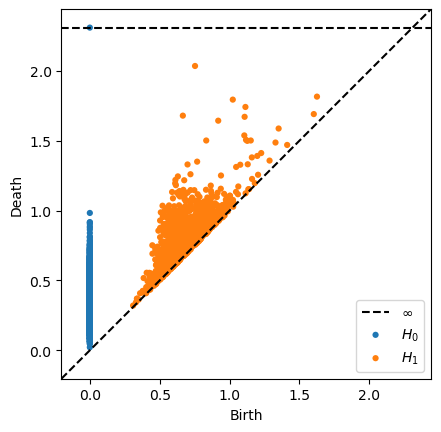

In [502]:
#some quantification ...
#for example, ripser uses persistent cohomology to quantify the topology of a point cloud by calculating Betti numbers
rips = Rips()
diagrams = rips.fit_transform(embeddings[0])
rips.plot(diagrams)

In [487]:
#decoding skipped